## Train experiments with a simple autoencoder as DR

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

import torch
from torch import nn
import matplotlib.pyplot as plt

# local imports
from setup import setup_device, setup_datamodule, load_model
from adapters.main import capture_convolution_layers
from dimensionality_reduction.feature_autoencoder import FeatureAutoencoder



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:2')
print(device, type(device))

cuda:2 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

In [6]:
# no. of epochs for training
EPOCHS_COUNT = 30
LEARNING_RATE = 1e-3

# output dims of dim reduction
OUT_DIMS = 3

# display results for a selected sample
SAMPLE_ID = 5

In [7]:
# LAYER_ID = 10
# LAYER_ID = 110
LAYER_NAME = 'model.model.1.submodule.0.conv.unit0.adn.A'

In [8]:
import wandb

BATCH_SIZE = 32
# Initialize wandb
wandb.init(project="simple-autoencoder-training", config={"learning_rate": LEARNING_RATE, "epochs": EPOCHS_COUNT, "batch_size": BATCH_SIZE})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vaklr (vaklr-bonn). Use `wandb login --relogin` to force relogin


### Preparation

Take the first batch from the datamodule

In [9]:
data_batch = next(iter(datamodule.val_dataloader()))

data_sample = data_batch['input']
data_sample.size() # [batch size, channels, width, hegiht]

torch.Size([32, 1, 256, 256])

Use hooks to capture hidden layer activations in the batch

In [10]:
wrapper, layer_names = capture_convolution_layers(model, device, data_sample)

In [11]:
# layer_samples = wrapper.layer_activations[layer_names[LAYER_ID]]
layer_samples = wrapper.layer_activations[LAYER_NAME]

print(f"shape of the selected layer ([COUNT, C, H, W]): {layer_samples.size()}")

shape of the selected layer ([COUNT, C, H, W]): torch.Size([32, 32, 64, 64])


In [12]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

## Experiments (single & batch)

Define a train function

In [13]:
def train_batch(autoencoder, num_epochs: int, samples, logger = None):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

    for epoch in range(num_epochs):
        epoch_loss = .0
        optimizer.zero_grad()
        
        for image in samples:
            _latent, reconstructed = autoencoder(image)
            loss = criterion(reconstructed, image)
            epoch_loss += loss

        if logger:
                logger({ "epoch_loss": epoch_loss/len(samples) })

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(samples):.4f}")
        epoch_loss.backward()
        optimizer.step()

    return autoencoder


Define visualization functions:

In [14]:
def visualize(image):
    if image.shape[0] > 3:  # If more than 3 channels, average channels
        # return image.mean(axis=0)
        return image[0]
    else:  # If 3 or fewer channels, just transpose to match image format
        return image.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

In [15]:
def plot_results(orig, reconstr, latent):
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(visualize(orig), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Reconstructed Image
    axes[1].imshow(visualize(reconstr), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    # Latent Representation (3 channels, like RGB)
    axes[2].imshow(latent.transpose(1, 2, 0))  # Transpose for [H, W, C]
    axes[2].set_title("Latent Representation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

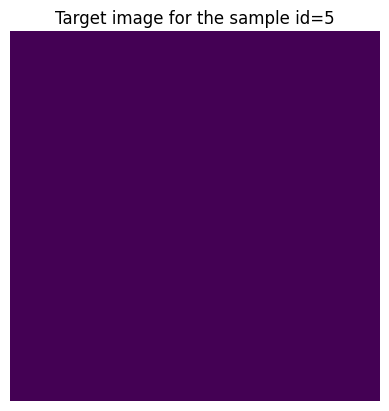

In [16]:
data_sample_target = data_batch['target'][SAMPLE_ID]
print(data_sample_target.size())

plt.imshow(data_sample_target.detach().numpy().transpose(1, 2, 0))
plt.title(f'Target image for the sample id={SAMPLE_ID}')
plt.axis("off")

### Single Layer Training

Create an instance of Autoencoder for training

In [17]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

single_autoencoder = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [18]:
single_autoencoder = train_batch(single_autoencoder, EPOCHS_COUNT, [layer_samples[SAMPLE_ID]])

Epoch [1/30], Loss: 0.9996
Epoch [2/30], Loss: 0.9919
Epoch [3/30], Loss: 0.9690
Epoch [4/30], Loss: 0.9253
Epoch [5/30], Loss: 0.8504
Epoch [6/30], Loss: 0.7518
Epoch [7/30], Loss: 0.6929
Epoch [8/30], Loss: 0.5860
Epoch [9/30], Loss: 0.5046
Epoch [10/30], Loss: 0.4834
Epoch [11/30], Loss: 0.4590
Epoch [12/30], Loss: 0.4461
Epoch [13/30], Loss: 0.4219
Epoch [14/30], Loss: 0.4152
Epoch [15/30], Loss: 0.4039
Epoch [16/30], Loss: 0.3881
Epoch [17/30], Loss: 0.3776
Epoch [18/30], Loss: 0.3707
Epoch [19/30], Loss: 0.3651
Epoch [20/30], Loss: 0.3561
Epoch [21/30], Loss: 0.3460
Epoch [22/30], Loss: 0.3386
Epoch [23/30], Loss: 0.3318
Epoch [24/30], Loss: 0.3218
Epoch [25/30], Loss: 0.3138
Epoch [26/30], Loss: 0.3103
Epoch [27/30], Loss: 0.3042
Epoch [28/30], Loss: 0.2961
Epoch [29/30], Loss: 0.2886
Epoch [30/30], Loss: 0.2820


Show the results

In [19]:
selected_sample = layer_samples[SAMPLE_ID]
latent, reconstructed = single_autoencoder(selected_sample)

In [20]:
original_np = selected_sample.detach().numpy()
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.589687..4.543755].


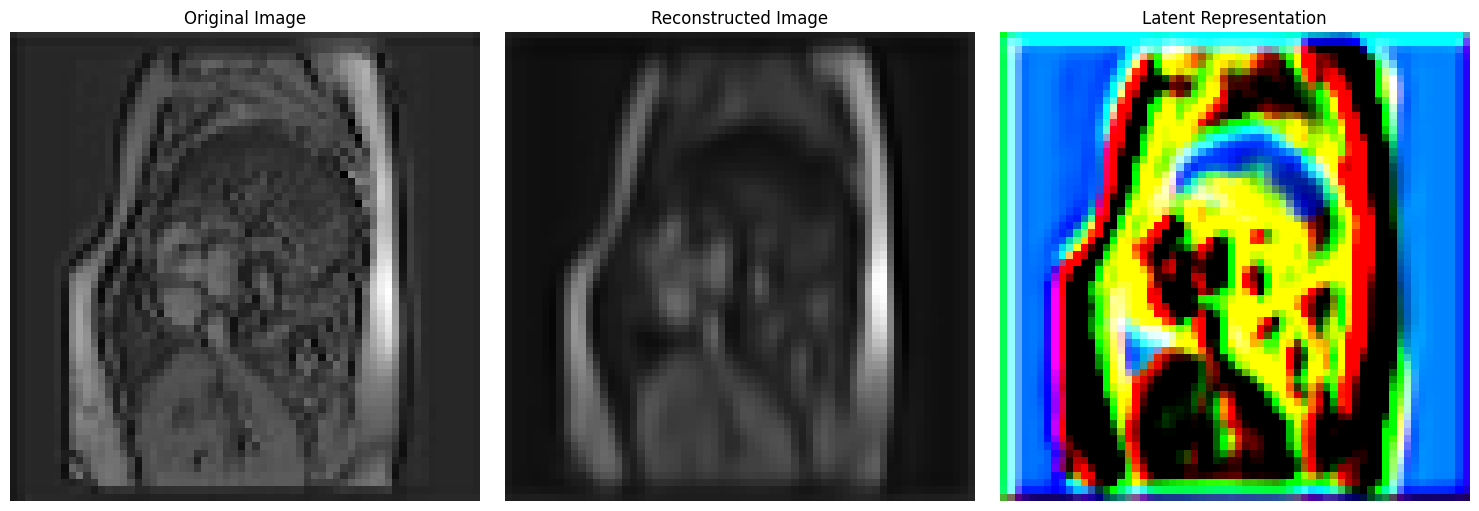

In [21]:
plot_results(original_np, reconstructed_np, latent_np)

In [22]:
import numpy as np

mse_error = np.mean((original_np - reconstructed_np) ** 2)

print(f"MSE Error: {mse_error.item()}")


MSE Error: 0.27714574337005615


### Single Batch Training

In [23]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

autoencoder_batch = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [24]:
autoencoder_batch = train_batch(autoencoder_batch, EPOCHS_COUNT, layer_samples)

Epoch [1/30], Loss: 1.0001
Epoch [2/30], Loss: 0.9943
Epoch [3/30], Loss: 0.9728
Epoch [4/30], Loss: 0.9330
Epoch [5/30], Loss: 0.8618
Epoch [6/30], Loss: 0.7657
Epoch [7/30], Loss: 0.7338
Epoch [8/30], Loss: 0.6240
Epoch [9/30], Loss: 0.6261
Epoch [10/30], Loss: 0.6262
Epoch [11/30], Loss: 0.5772
Epoch [12/30], Loss: 0.5514
Epoch [13/30], Loss: 0.5480
Epoch [14/30], Loss: 0.5433
Epoch [15/30], Loss: 0.5225
Epoch [16/30], Loss: 0.4951
Epoch [17/30], Loss: 0.4736
Epoch [18/30], Loss: 0.4554
Epoch [19/30], Loss: 0.4398
Epoch [20/30], Loss: 0.4308
Epoch [21/30], Loss: 0.4182
Epoch [22/30], Loss: 0.3986
Epoch [23/30], Loss: 0.3842
Epoch [24/30], Loss: 0.3725
Epoch [25/30], Loss: 0.3586
Epoch [26/30], Loss: 0.3495
Epoch [27/30], Loss: 0.3442
Epoch [28/30], Loss: 0.3372
Epoch [29/30], Loss: 0.3299
Epoch [30/30], Loss: 0.3208


Show the results

In [25]:
selected_sample = layer_samples[SAMPLE_ID]
latent_batch, reconstructed_batch = autoencoder_batch(selected_sample)

In [26]:
original_batch_np = selected_sample.detach().numpy()
latent_batch_np = latent_batch.detach().numpy()
reconstructed_batch_np = reconstructed_batch.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.6880636..11.730665].


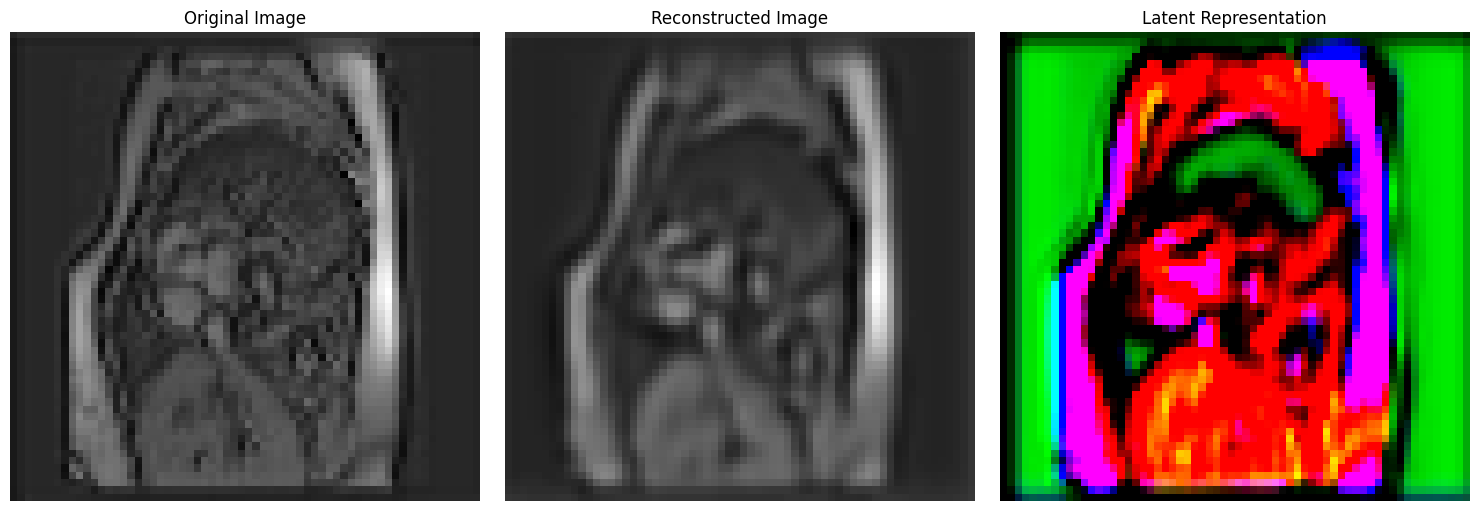

In [27]:
plot_results(original_batch_np, reconstructed_batch_np, latent_batch_np)

In [28]:
mse_error = np.mean((original_np - reconstructed_batch_np) ** 2)

print(f"MSE Error: {mse_error.item()}")

MSE Error: 0.29363593459129333


## Whole Dataset Training

### Train new autoencoded

In [14]:
from dimensionality_reduction.train import train_dr

In [15]:
autoencoder_dataset = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=32 and out channels=3


In [16]:
# Track model parameters
wandb.watch(autoencoder_dataset, log="all", log_freq=10)

In [17]:
train_dr(autoencoder=autoencoder_dataset, datamodule=datamodule, model=model, device=device,
                       logger=wandb.log, layer_names=[LAYER_NAME], num_epochs=EPOCHS_COUNT)

Epoch [1/30], Loss: 37.307799
Epoch [2/30], Loss: 9.608831
Epoch [3/30], Loss: 7.345538
Epoch [4/30], Loss: 6.219374
Epoch [5/30], Loss: 5.599869
Epoch [6/30], Loss: 5.170984
Epoch [7/30], Loss: 4.869134
Epoch [8/30], Loss: 4.672767
Epoch [9/30], Loss: 4.463126
Epoch [10/30], Loss: 4.373555
Epoch [11/30], Loss: 4.223715
Epoch [12/30], Loss: 4.161680
Epoch [13/30], Loss: 4.059301
Epoch [14/30], Loss: 4.008651
Epoch [15/30], Loss: 3.914349
Epoch [16/30], Loss: 3.870544
Epoch [17/30], Loss: 3.830734
Epoch [18/30], Loss: 3.752542
Epoch [19/30], Loss: 3.745197
Epoch [20/30], Loss: 3.685490
Epoch [21/30], Loss: 3.643561
Epoch [22/30], Loss: 3.615911
Epoch [23/30], Loss: 3.586025
Epoch [24/30], Loss: 3.541805
Epoch [25/30], Loss: 3.526266
Epoch [26/30], Loss: 3.495696
Epoch [27/30], Loss: 3.467890
Epoch [28/30], Loss: 3.451705
Epoch [29/30], Loss: 3.421059
Epoch [30/30], Loss: 3.390899


FeatureAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [18]:
wandb.finish()

epoch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_batch_loss,█▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_loss,3.3909
train_batch_loss,0.02413


In [19]:
import torch

def print_image_error(original, reconstruction):
    criterion = torch.nn.MSELoss()
    mse_error = criterion(original, reconstruction).item()

    print(f"MSE Error: {mse_error}")

In [26]:
selected_sample = layer_samples[10]
original_np = selected_sample.detach().numpy()

In [27]:
latent, reconstructed = autoencoder_dataset(selected_sample)
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../visualization_utils/color_space_transformers.py:27: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 186 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


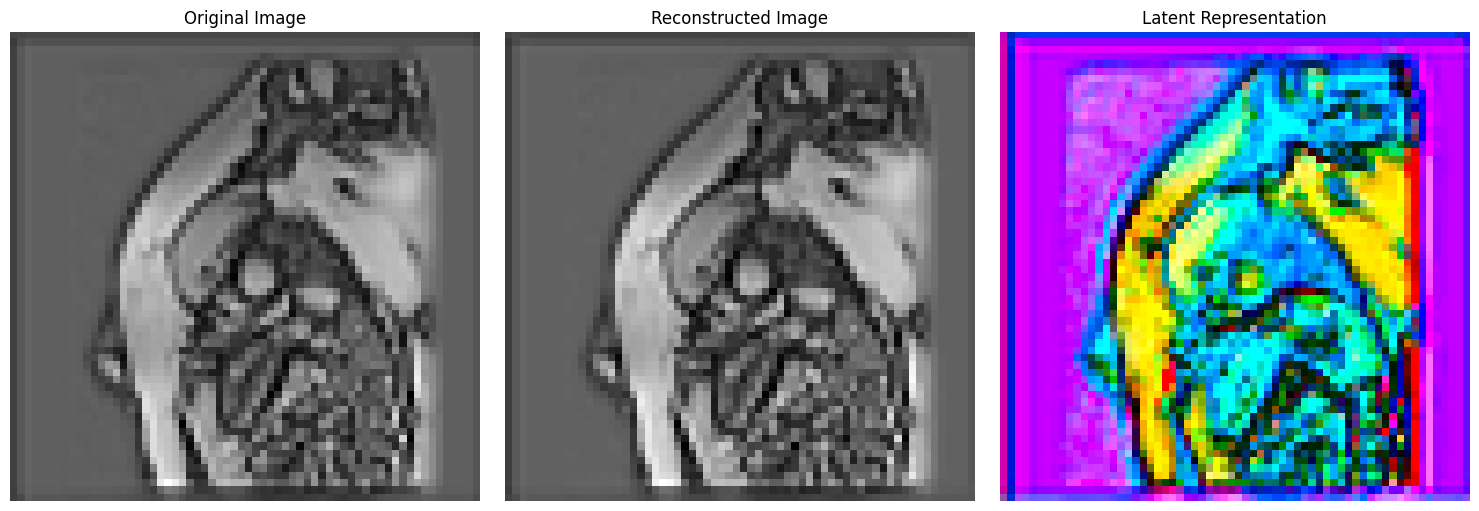

MSE Error: 0.021367821842432022


In [28]:
from visualization_utils.layer_visualizer import LayerVisualizer

layer_visualizer = LayerVisualizer()
layer_visualizer.plot(original_np, reconstructed_np, latent_np)

print_image_error(selected_sample, reconstructed)

### Save  & load the autoencoder

In [ ]:
from model_saver import ModelSaver

FILE_NAME = 'best_simple_encoder_e30'

saver = ModelSaver('./simple_autoencoders')

saver.save_model_config(autoencoder_dataset, file_name=FILE_NAME)

Model saved to ./simple_autoencoders/best_simple_encoder_e30.pth


Load saved autoencoder

In [8]:
# Initialize the same autoencoder structure
autoencoder_saved = FeatureAutoencoder(32, 3)

from model_saver import ModelSaver
saver = ModelSaver('./simple_autoencoders')
saver.load_autoencoder_config(autoencoder_saved, 'best_simple_encoder_e30')

defined an autoencoder with input channels=32 and out channels=3
Model loaded successfully


/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../model_saver.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(autoencod

In [9]:
from dimensionality_reduction.train import get_avg_error

print(get_avg_error(autoencoder=autoencoder_saved, dataloader=datamodule.train_dataloader,
                                model=model, device='cuda:2',
                                selected_layer_names=[LAYER_NAME]))

print(get_avg_error(autoencoder=autoencoder_saved, dataloader=datamodule.val_dataloader,
                                model=model, device='cuda:2',
                                selected_layer_names=[LAYER_NAME]))

0.025920015049876868
0.025804498116485775
